# INR vs USD currency predictor using  Time-Series 
We are going to predict the possible value of INR compared to USD by performing Time-Series predictoin in Tensorflow


### 1. Aim
The aim is to create a model for predicting INR value agains USD by performing Time-Series-Prediction using last 8 years Dataset using Neural Networks


### 2. Setup

In [119]:
#check the version on TF (make sure it's 2.0+)
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



### 3.1 Fetching dataset

In [122]:
df=pd.read_csv('/content/drive/My Drive/INR-USD-Prediction/dataset/usd-inr.csv')
df.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,12/05/20,75.062,75.945,75.962,75.049,4.05K,-1.09%
1,11/05/20,75.888,75.535,75.925,75.450,5.78K,0.47%
2,08/05/20,75.535,75.588,75.645,75.262,3.32K,-0.34%
3,07/05/20,75.794,76.100,76.145,75.773,0.48K,-0.41%
4,06/05/20,76.105,75.805,76.108,75.630,3.51K,0.52%


In [123]:
df.shape

(1847, 7)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1847 entries, 0 to 1846
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1847 non-null   object 
 1   Price   1847 non-null   float64
 2   Open    1847 non-null   float64
 3   High    1847 non-null   float64
 4   Low     1847 non-null   float64
 5   Volume  1847 non-null   object 
 6   Chg%    1847 non-null   object 
dtypes: float64(4), object(3)
memory usage: 101.1+ KB


Since we only need the time stamp and the price, hence we'll remove the rest of the columns except Chg% for now.

In [125]:
df=df.drop(['Open','High','Low','Volume'],axis=1)
df.head()

,Date,Price,Chg%
0,12/05/20,75.062,-1.09%
1,11/05/20,75.888,0.47%
2,08/05/20,75.535,-0.34%
3,07/05/20,75.794,-0.41%
4,06/05/20,76.105,0.52%


In [133]:
#creating varibles 'step' and 'time_step'
days=len(df.Date)
time_step=[]
price=[]
for i in range(days):
  time_step.append(i)
  price.append(df['Price'][i])

price=price[::-1]
#since the data we've is in opposite order 
series=np.array(price)

time=np.array(time_step)

days,time[:4],series[:4]


(1847, array([0, 1, 2, 3]), array([54.55, 53.97, 54.18, 54.03]))

### 3.2 Plotting Dataset
As we've the data in desired format i.e with timestamp and the values, we can plot the time-series

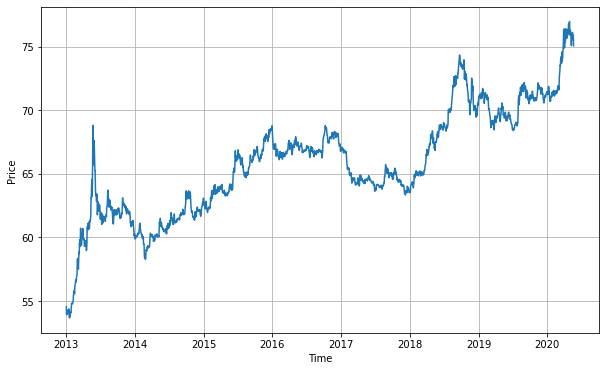

In [151]:
plt.figure(figsize=(10, 6))
plt.plot(2013+(time/250),series)
plt.ylabel('Price')
plt.xlabel('Time')

plt.grid(True)

plt.show()

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [0]:
print(rnn_forecast)